# Introduction to Convolutional Neural Networks and Computer Vision with tensorflow

Computer vision is the practive of writting algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front

In [1]:
# Get the data (Food 101 dataset only using pizza & steak classes)
# We start with a smaller dataset so we can experiment quickly and figure what works before scaling up

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
#Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2026-02-20 10:49:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4001:808::201b, 2a00:1450:4001:817::201b, 2a00:1450:4001:81c::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4001:808::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M  15.6MB/s    in 7.2s    

2026-02-20 10:49:54 (14.4 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



## Inspect the data

A very crucial step at the begining of any ML project is becoming one with the data.

For CV projects, this usually means visualizing many samples of your data

In [2]:
import os

#Walk through pizza_steak directory and list numeber of file
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak/test
There are 1 directories and 250 images in pizza_steak/test/steak
There are 0 directories and 1 images in pizza_steak/test/steak/.ipynb_checkpoints
There are 0 directories and 250 images in pizza_steak/test/pizza
There are 2 directories and 0 images in pizza_steak/train
There are 0 directories and 750 images in pizza_steak/train/steak
There are 0 directories and 750 images in pizza_steak/train/pizza


In [3]:
#Get the classnames programatically
import pathlib
import numpy as np 

data_dir= pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) #Create a list of class_names from the subdirectories

print(class_names)

['pizza' 'steak']


In [4]:
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    #Setupt the target directory 
    target_folder = target_dir + target_class

    #Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)

    #Read the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")
    return img
    

['2365046.jpg']
Image shape: (512, 512, 3)


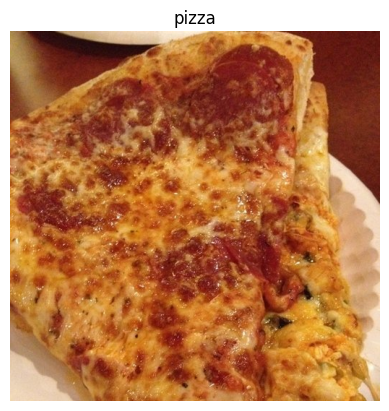

In [5]:
img = view_random_image(target_dir="pizza_steak/train/",
                       target_class="pizza")

In [6]:
import tensorflow as tf
tf.constant(img)

2026-02-20 10:50:00.021185: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-02-20 10:50:00.021215: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-20 10:50:00.021221: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-20 10:50:00.021412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-20 10:50:00.021420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[163, 132,  75],
        [164, 133,  76],
        [167, 134,  81],
        ...,
        [ 85,  22,  15],
        [ 87,  24,  17],
        [ 87,  24,  17]],

       [[171, 140,  83],
        [163, 132,  75],
        [160, 127,  73],
        ...,
        [ 86,  23,  16],
        [ 88,  25,  18],
        [ 91,  28,  21]],

       [[175, 145,  85],
        [167, 137,  77],
        [162, 130,  73],
        ...,
        [ 86,  21,  15],
        [ 89,  24,  18],
        [ 95,  30,  24]],

       ...,

       [[242, 218, 180],
        [240, 216, 178],
        [239, 215, 179],
        ...,
        [189, 139,  66],
        [195, 142,  74],
        [194, 141,  73]],

       [[241, 217, 179],
        [238, 214, 176],
        [237, 213, 177],
        ...,
        [187, 135,  62],
        [187, 133,  63],
        [191, 137,  67]],

       [[241, 217, 179],
        [237, 213, 175],
        [237, 213, 177],
        ...,
        [186, 134,  5

Many ML models, including NN prefer the values they work with to be between 0 and 1.

One of the most common preprocessing steps for working with images is ti scale (also referred as **normalize**) their pixel values by dividing the image array by 255 (since 255 is the max. pixel value)

## End-to-end example

To build a CNN we need a way to: 

1. Load our images
2. Preprocess our images
3. Build a CNN to find patterns in our images
4. Compile our CNN
5. Fit the CNN to our training data

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Set seed
tf.random.set_seed(42)

# Preprocess data (get all the pixels values between 0 & 1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set paths to our data directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

#Import data from directories and turn it into batches 
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode="binary",
                                              seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode="binary",
                                              seed=42)

#Build a CNN model based on the Tiny VGG
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                          kernel_size=3,
                          activation="relu",
                          input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

#Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
#Fit the model
history_1 = model_1.fit(train_data, 
                        epochs=5, 
                        steps_per_epoch=len(train_data), 
                        validation_data=valid_data, 
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 501 images belonging to 2 classes.


/Users/sergioperal/Projects/TF/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


2026-02-20 10:50:00.645658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6567 - loss: 0.6280 - val_accuracy: 0.8124 - val_loss: 0.4253
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7827 - loss: 0.4774 - val_accuracy: 0.7246 - val_loss: 0.5191
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7953 - loss: 0.4526 - val_accuracy: 0.8523 - val_loss: 0.3901
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8447 - loss: 0.3820 - val_accuracy: 0.8503 - val_loss: 0.3673
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8580 - loss: 0.3421 - val_accuracy: 0.8822 - val_loss: 0.3293


In [8]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

## Use the trained model on a different dataset

In [17]:
# Set random seed
tf.random.set_seed(4)

# Create a model to replicate the tensorflow playground model
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

#Compile the model
model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Fit the model
model_2.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5107 - loss: 64.7627 - val_accuracy: 0.4990 - val_loss: 70.4981
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5393 - loss: 33.8359 - val_accuracy: 0.6647 - val_loss: 5.1044
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6727 - loss: 5.5169 - val_accuracy: 0.6627 - val_loss: 5.0517
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6833 - loss: 5.2506 - val_accuracy: 0.6607 - val_loss: 5.1527
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6760 - loss: 5.2319 - val_accuracy: 0.6687 - val_loss: 4.9269
